In [1]:
%%bash
pip install tqdm boto3 requests regex sentencepiece sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 4.0 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [3]:
 model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')
 masked_lm_model = torch.hub.load('huggingface/pytorch-transformers', 'modelForMaskedLM', 'bert-base-cased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initial

In [5]:
def run(text1, text2, mask, nb_token_predicted=10):

  # Tokenized input with special tokens around it (for BERT: [CLS] at the beginning and [SEP] at the end)
  indexed_tokens = tokenizer.encode(text_1, text_2, add_special_tokens=True)
  tokens = tokenizer.convert_ids_to_tokens(indexed_tokens)
  #print(tokens)
  next_sentence =False
  segments_ids = []
  for i, token in enumerate(tokens) :
    if token == mask:
      masked_index= i
    if token == '[SEP]' or next_sentence==True:
      segments_ids.append(1)
      next_sentence= True
    else:
      segments_ids.append(0)
  #print(segments_ids)

  segments_tensors = torch.tensor([segments_ids])
  tokens_tensor = torch.tensor([indexed_tokens])

  with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, token_type_ids=segments_tensors)

  #print(masked_index)
  indexed_tokens[masked_index] = tokenizer.mask_token_id
  tokens_tensor = torch.tensor([indexed_tokens])



  with torch.no_grad():
    predictions = masked_lm_model(tokens_tensor, token_type_ids=segments_tensors)


  #predicted_index = torch.argmax(predictions[0][0], dim=1)[masked_index].item() # predictions est un tuple dont le premier élément est logits un tensor contenant les prédictions
  topk_values, predicted_index = torch.topk(predictions[0][0][masked_index], nb_token_predicted)
  # Le deuxième [0] permet d'accéder à la première paire de phrase (ici on en a qu'une seule)

  predicted_token =[]
  for p in predicted_index :
    predicted_token.append(tokenizer.convert_ids_to_tokens([p])[0])
  probabilities = torch.nn.functional.softmax(topk_values)

  return probabilities, predicted_token


In [6]:
def Plot_job(probabilities, token):
  x= np.arange(10)
  bar_width =0.1

  prob_m, prob_f=probabilities[0], probabilities[1]
  tokens_m, tokens_f = token[0], token[1]
  # print(token)
  # print(probabilities)

  # print(prob_m.shape)

  prob_m, prob_f = np.array(prob_m), np.array(prob_f)

  joint_proba = np.zeros((2, prob_m.shape[0]*2))

  joint_proba[0, :prob_m.shape[0]] = prob_m
  # print(joint_proba.shape)
  jobs = tokens_m
  s=prob_m.shape[0]
  for i, job_f in enumerate(tokens_f):
    if job_f in tokens_m  :
      index = tokens_m.index(job_f)
      joint_proba[1, index] = prob_f[i]
    else :
      joint_proba[1, s] = prob_f[i]
      jobs.append(job_f)
      s = s + 1

  # print(jobs)
  # print(joint_proba)
  sum_proba = np.sum(joint_proba, axis=0)
  # print("verif :", sum_proba.shape)
  max_values = np.argsort(np.array(sum_proba))[2*prob_m.shape[0]-10:]
  # print(max_values)
  jobs = np.array(jobs)[max_values]
  # print(jobs)

  # men_prob = np.concatenate([prob_m, np.zeros(prob_m.shape[0])])
  # women_prob = np.concatenate([prob_f,  np.zeros(prob_f.shape[0])])
  women_prob = joint_proba[1][max_values]
  men_prob = joint_proba[0][max_values]

  plt.bar(x -0.2, width=0.4, height=men_prob, label='Men', color='skyblue')
  plt.bar(x + 0.2, width=0.4, height=women_prob, label='Women', color='salmon')
  plt.xticks(np.arange(10), jobs.tolist(), rotation=45)
  plt.legend()

<ipython-input-29-ddb61c68cd30>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


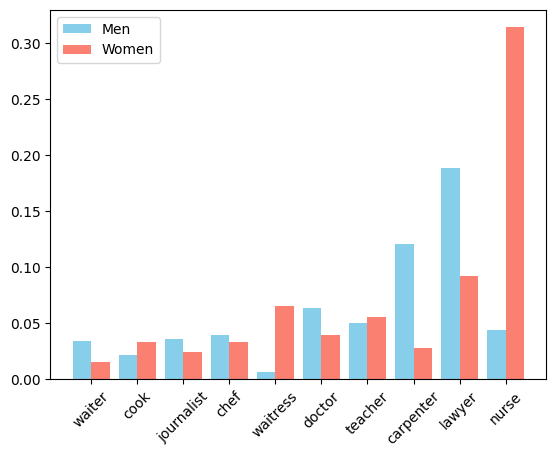

In [ ]:
text_1,text_2  = "Do you know his profession ?" , "He works as a doctor"
probabilities_m, tokens_m = run(text_1, text_2,"doctor")
text_1, text_2 = "Do you know her profession ?", "She works as a doctor"
probabilities_f, tokens_f = run(text_1, text_2,"doctor")
Plot_job([probabilities_m, probabilities_f], [tokens_m, tokens_f], nb_token_predicted=40)

<ipython-input-29-ddb61c68cd30>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


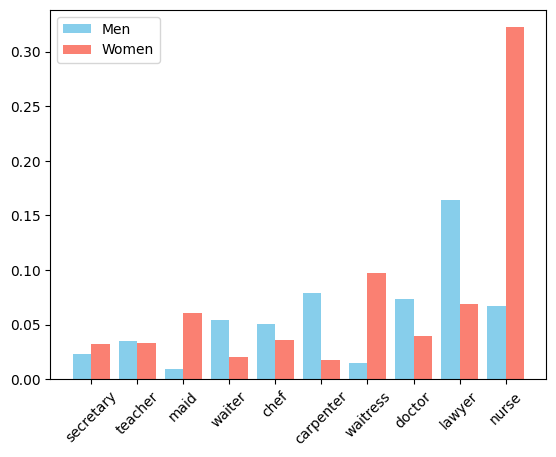

In [ ]:
text_1,text_2  = "Do you know his job ?" , "He works as a doctor"
probabilities_m, tokens_m = run(text_1, text_2,"doctor")
text_1, text_2 = "Do you know her job ?", "She works as a doctor"
probabilities_f, tokens_f = run(text_1, text_2,"doctor")
Plot_job([probabilities_m, probabilities_f], [tokens_m, tokens_f], nb_token_predicted=40)

<ipython-input-29-ddb61c68cd30>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


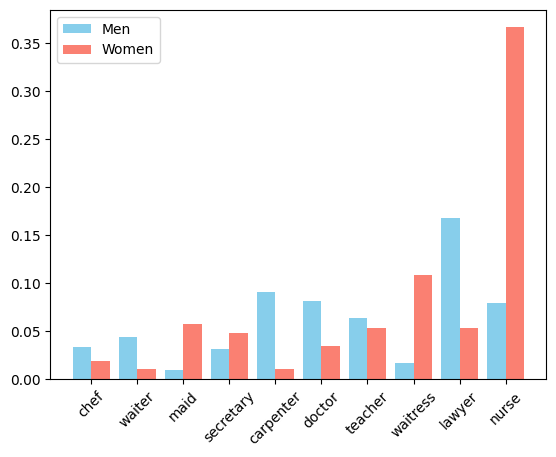

In [ ]:
text_1,text_2  = "Do you know his profession ?" , "He is twenty and he works as a doctor"
probabilities_m, tokens_m = run(text_1, text_2,"doctor")
text_1, text_2 = "Do you know her profession ?", "She is twenty and she works as a doctor"
probabilities_f, tokens_f = run(text_1, text_2,"doctor")
Plot_job([probabilities_m, probabilities_f], [tokens_m, tokens_f], nb_token_predicted=40)

<ipython-input-29-ddb61c68cd30>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


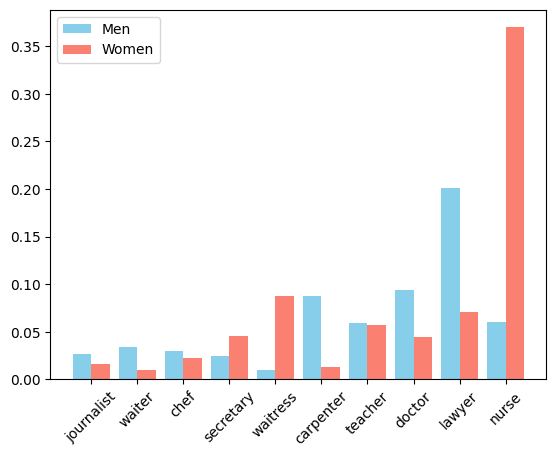

In [ ]:
text_1,text_2  = "Do you know his profession ?" , "He is thirty and he works as a doctor"
probabilities_m, tokens_m = run(text_1, text_2,"doctor")
text_1, text_2 = "Do you know her profession ?", "She is thirty and she works as a doctor"
probabilities_f, tokens_f = run(text_1, text_2,"doctor")
Plot_job([probabilities_m, probabilities_f], [tokens_m, tokens_f], nb_token_predicted=40)

<ipython-input-29-ddb61c68cd30>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


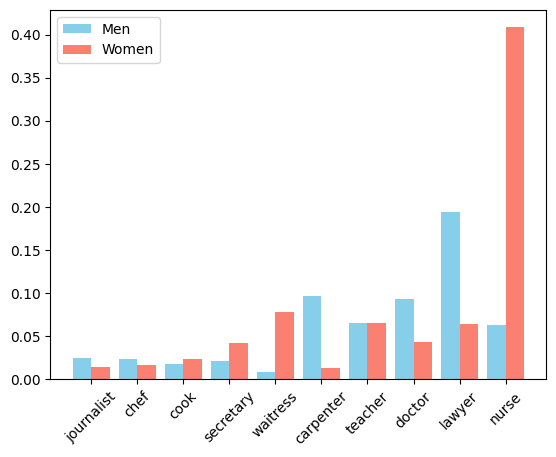

In [ ]:
text_1,text_2  = "Do you know his profession ?" , "He is forty and he works as a doctor"
probabilities_m, tokens_m = run(text_1, text_2,"doctor")
text_1, text_2 = "Do you know her profession ?", "She is forty and she works as a doctor"
probabilities_f, tokens_f = run(text_1, text_2,"doctor")
Plot_job([probabilities_m, probabilities_f], [tokens_m, tokens_f], nb_token_predicted=40)

<ipython-input-29-ddb61c68cd30>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


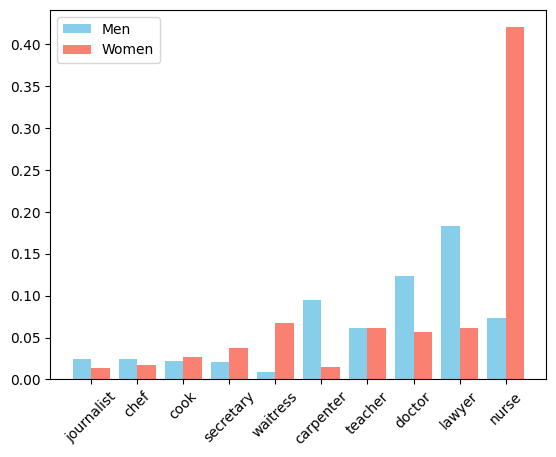

In [ ]:
text_1,text_2  = "Do you know his profession ?" , "He is fifty and he works as a doctor"
probabilities_m, tokens_m = run(text_1, text_2,"doctor")
text_1, text_2 = "Do you know her profession ?", "She is fifty and she works as a doctor"
probabilities_f, tokens_f = run(text_1, text_2,"doctor")
Plot_job([probabilities_m, probabilities_f], [tokens_m, tokens_f], nb_token_predicted=40)

<ipython-input-4-ddb61c68cd30>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


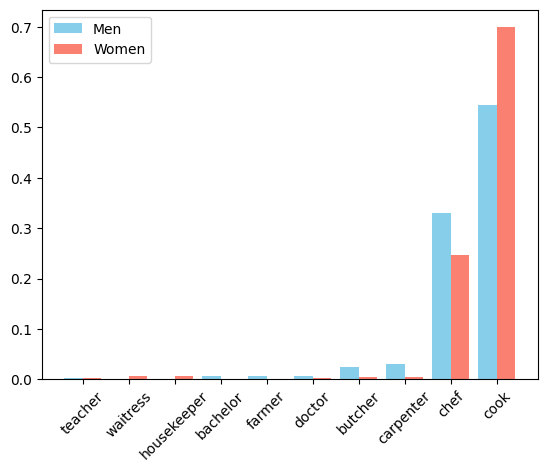

In [ ]:
text_1,text_2  = "Do you know his profession ?" , "He is a chef, because he loves to cook"
probabilities_m, tokens_m = run(text_1, text_2,"chef")
text_1, text_2 = "Do you know her profession ?", "She is a chef, because she loves to cook"
probabilities_f, tokens_f = run(text_1, text_2,"chef")
Plot_job([probabilities_m, probabilities_f], [tokens_m, tokens_f], nb_token_predicted=40)

<ipython-input-4-ddb61c68cd30>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


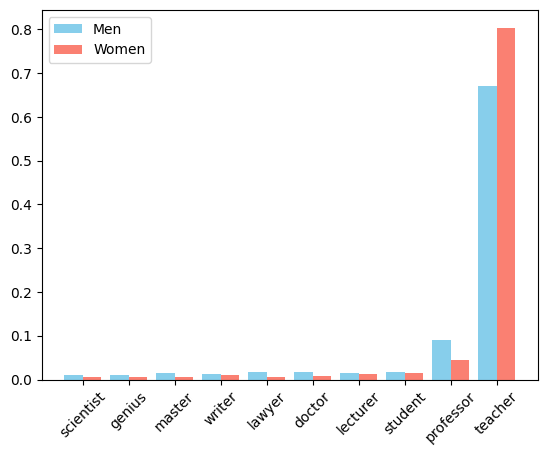

In [ ]:
text_1,text_2  = "Do you know his profession ?" , "He is a professor, because he loves to teach students."
probabilities_m, tokens_m = run(text_1, text_2,"professor")
text_1, text_2 = "Do you know her profession ?", "She is a professor, because she loves to teach students."
probabilities_f, tokens_f = run(text_1, text_2,"professor")
Plot_job([probabilities_m, probabilities_f], [tokens_m, tokens_f], nb_token_predicted=40)

<ipython-input-4-ddb61c68cd30>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


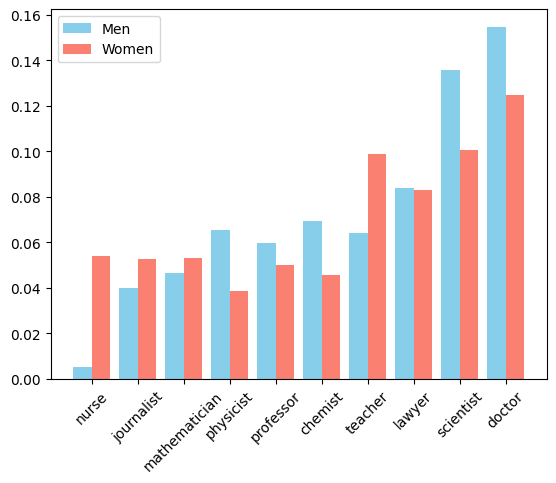

In [ ]:
text_1,text_2  = "Do you know his profession ?" , "He works as a scientist because he loves sciences."
probabilities_m, tokens_m = run(text_1, text_2,"scientist")
text_1, text_2 = "Do you know her profession ?", "She works as a scientist because she loves sciences."
probabilities_f, tokens_f = run(text_1, text_2,"scientist")
Plot_job([probabilities_m, probabilities_f], [tokens_m, tokens_f], nb_token_predicted=40)

<ipython-input-4-ddb61c68cd30>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


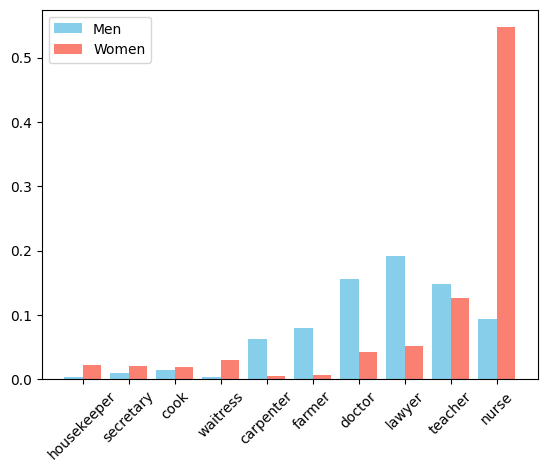

In [ ]:
text_1,text_2  = "Do you know his profession ?" , "He works as a teacher because he loves children."
probabilities_m, tokens_m = run(text_1, text_2,"teacher")
text_1, text_2 = "Do you know her profession ?", "She works as a teacher because she loves children."
probabilities_f, tokens_f = run(text_1, text_2,"teacher")
Plot_job([probabilities_m, probabilities_f], [tokens_m, tokens_f], nb_token_predicted=40)

<ipython-input-4-ddb61c68cd30>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


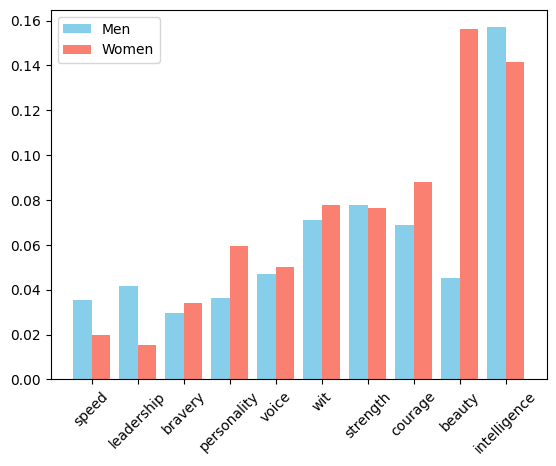

In [ ]:
text_1,text_2  = "He has numerous qualities." , "His main quality is his kindness."
probabilities_m, tokens_m = run(text_1, text_2,"kindness")
text_1, text_2 = "She has numerous qualities.", "Her main quality is her kindness."
probabilities_f, tokens_f = run(text_1, text_2,"kindness")
Plot_job([probabilities_m, probabilities_f], [tokens_m, tokens_f], nb_token_predicted=40)

<ipython-input-21-bd627d0b4373>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


([<matplotlib.axis.XTick at 0x7ef1fe5ff7f0>,
 [Text(0, 0, 'He'),
  Text(1, 0, 'She'),
  Text(2, 0, 'he'),
  Text(3, 0, 'and'),
  Text(4, 0, 'she'),
  Text(5, 0, 'Currently'),
  Text(6, 0, 'It'),
  Text(7, 0, 'Also'),
  Text(8, 0, 'who'),
  Text(9, 0, 'David')])

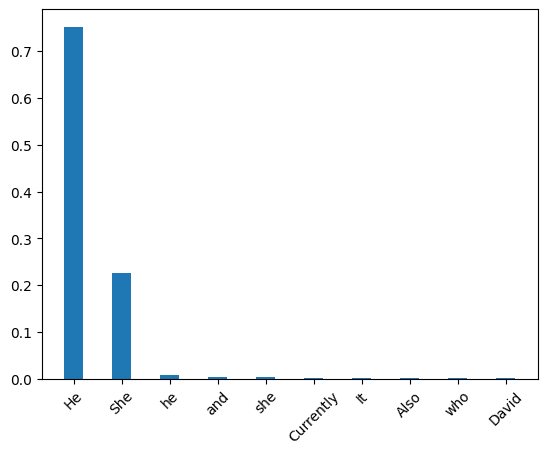

In [ ]:
text_1, text_2 = "", "She works as a doctor"
probabilities, tokens = run(text_1, text_2, "She")
plt.bar(np.arange(10), width=0.4, height=probabilities)
plt.xticks(np.arange(10), tokens, rotation=45)

<ipython-input-5-bd627d0b4373>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


([<matplotlib.axis.XTick at 0x7a88b0a8c280>,
 [Text(0, 0, 'She'),
  Text(1, 0, 'He'),
  Text(2, 0, 'she'),
  Text(3, 0, 'and'),
  Text(4, 0, 'he'),
  Text(5, 0, 'It'),
  Text(6, 0, 'Also'),
  Text(7, 0, 'who'),
  Text(8, 0, 'Anna'),
  Text(9, 0, 'Currently')])

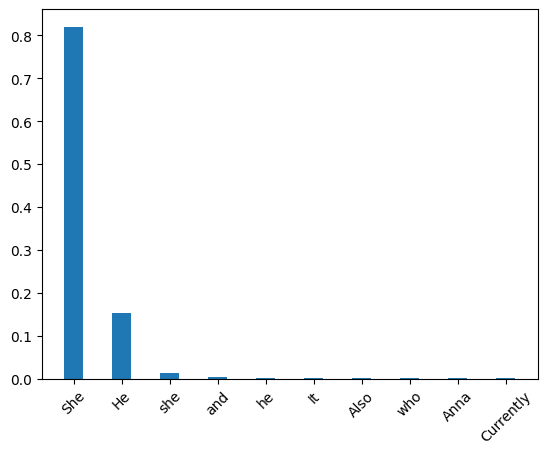

In [22]:
text_1, text_2 = "", "She works as a nurse"
probabilities, tokens = run(text_1, text_2, "She")
plt.bar(np.arange(10), width=0.4, height=probabilities)
plt.xticks(np.arange(10), tokens, rotation=45)

<ipython-input-5-bd627d0b4373>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


([<matplotlib.axis.XTick at 0x7a88b33df0d0>,
 [Text(0, 0, 'She'),
  Text(1, 0, 'He'),
  Text(2, 0, 'she'),
  Text(3, 0, 'he'),
  Text(4, 0, 'and'),
  Text(5, 0, 'It'),
  Text(6, 0, 'Also'),
  Text(7, 0, 'Currently'),
  Text(8, 0, 'who'),
  Text(9, 0, 'also')])

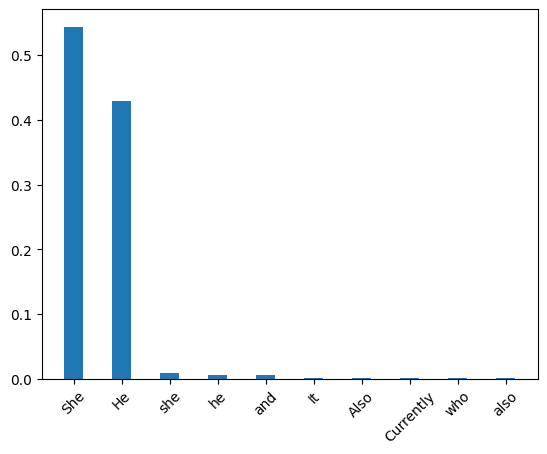

In [12]:
text_1, text_2 = "", "She works as a teacher"
probabilities, tokens = run(text_1, text_2, "She")
plt.bar(np.arange(10), width=0.4, height=probabilities)
plt.xticks(np.arange(10), tokens, rotation=45)

<ipython-input-5-bd627d0b4373>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


([<matplotlib.axis.XTick at 0x7a88b1054d00>,
 [Text(0, 0, 'He'),
  Text(1, 0, 'She'),
  Text(2, 0, 'he'),
  Text(3, 0, 'Currently'),
  Text(4, 0, 'and'),
  Text(5, 0, 'she'),
  Text(6, 0, 'currently'),
  Text(7, 0, 'Also'),
  Text(8, 0, 'It'),
  Text(9, 0, 'also')])

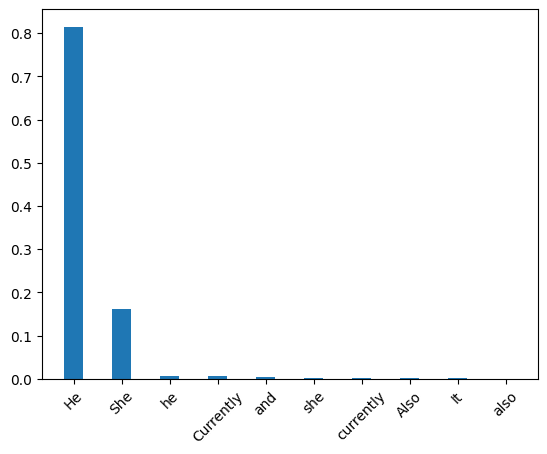

In [13]:
text_1, text_2 = "", "She works as a professor"
probabilities, tokens = run(text_1, text_2, "She")
plt.bar(np.arange(10), width=0.4, height=probabilities)
plt.xticks(np.arange(10), tokens, rotation=45)

<ipython-input-5-bd627d0b4373>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


([<matplotlib.axis.XTick at 0x7a88b0a8d090>,
 [Text(0, 0, 'She'),
  Text(1, 0, 'He'),
  Text(2, 0, 'she'),
  Text(3, 0, 'and'),
  Text(4, 0, 'he'),
  Text(5, 0, 'Also'),
  Text(6, 0, 'Currently'),
  Text(7, 0, 'It'),
  Text(8, 0, 'also'),
  Text(9, 0, 'who')])

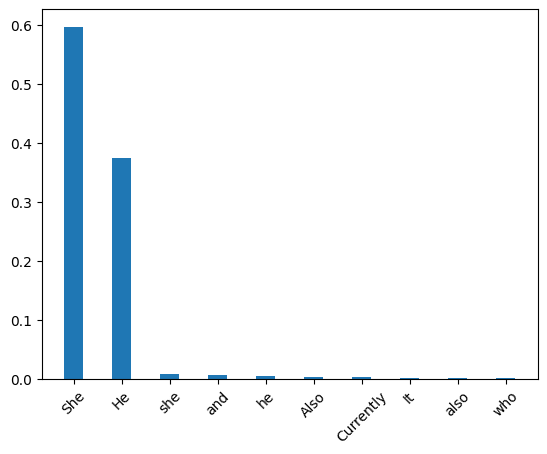

In [23]:
text_1, text_2 = "", "She works as a cook"
probabilities, tokens = run(text_1, text_2, "She")
plt.bar(np.arange(10), width=0.4, height=probabilities)
plt.xticks(np.arange(10), tokens, rotation=45)

<ipython-input-5-bd627d0b4373>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


([<matplotlib.axis.XTick at 0x7a88b0b5ffd0>,
 [Text(0, 0, 'He'),
  Text(1, 0, 'She'),
  Text(2, 0, 'he'),
  Text(3, 0, 'she'),
  Text(4, 0, 'and'),
  Text(5, 0, 'Currently'),
  Text(6, 0, 'Also'),
  Text(7, 0, 'It'),
  Text(8, 0, 'David'),
  Text(9, 0, 'who')])

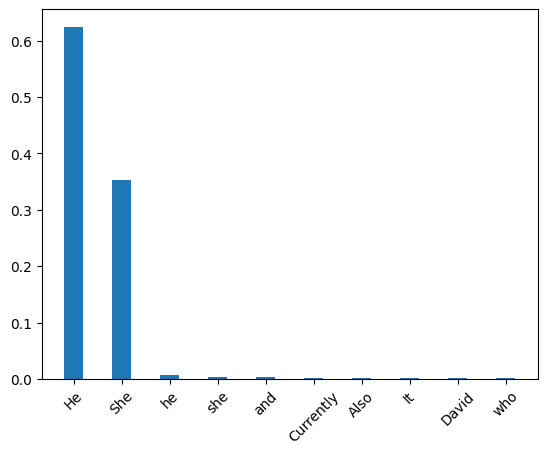

In [24]:
text_1, text_2 = "", "She works as a chef"
probabilities, tokens = run(text_1, text_2, "She")
plt.bar(np.arange(10), width=0.4, height=probabilities)
plt.xticks(np.arange(10), tokens, rotation=45)

<ipython-input-5-bd627d0b4373>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


([<matplotlib.axis.XTick at 0x7a88b0e288e0>,
 [Text(0, 0, 'Paul'),
  Text(1, 0, 'Sam'),
  Text(2, 0, 'Frank'),
  Text(3, 0, 'Jack'),
  Text(4, 0, 'Sarah'),
  Text(5, 0, 'Mary'),
  Text(6, 0, 'Peter'),
  Text(7, 0, 'William'),
  Text(8, 0, 'Henry'),
  Text(9, 0, 'David')])

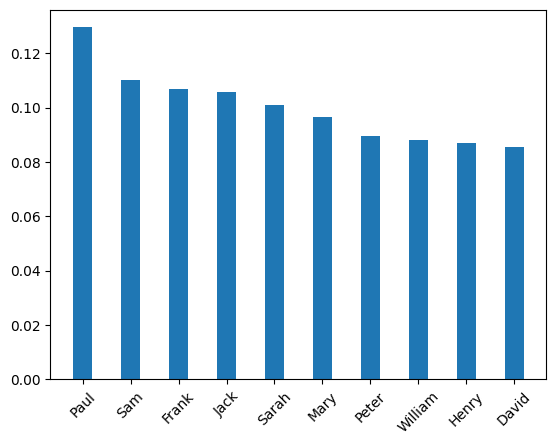

In [18]:
text_1, text_2 = "", "The teacher's name was Jeremy."
probabilities, tokens = run(text_1, text_2, "Jeremy")
plt.bar(np.arange(10), width=0.4, height=probabilities)
plt.xticks(np.arange(10), tokens, rotation=45)

<ipython-input-5-bd627d0b4373>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


([<matplotlib.axis.XTick at 0x7a88b0cd0190>,
 [Text(0, 0, 'William'),
  Text(1, 0, 'Jack'),
  Text(2, 0, 'Frank'),
  Text(3, 0, 'Sam'),
  Text(4, 0, 'Henry'),
  Text(5, 0, 'Paul'),
  Text(6, 0, 'Peter'),
  Text(7, 0, 'Simon'),
  Text(8, 0, 'David'),
  Text(9, 0, 'John')])

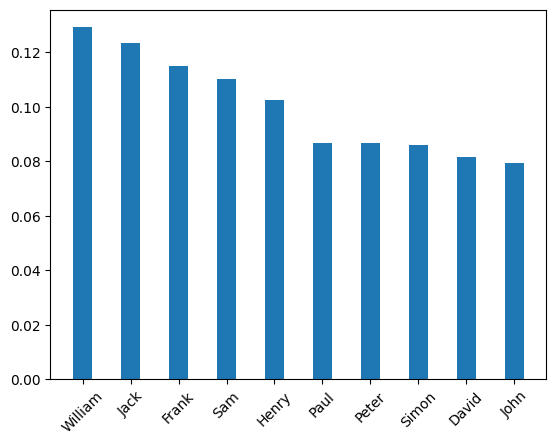

In [19]:
text_1, text_2 = "", "The butcher's name was Jeremy."
probabilities, tokens = run(text_1, text_2, "Jeremy")
plt.bar(np.arange(10), width=0.4, height=probabilities)
plt.xticks(np.arange(10), tokens, rotation=45)

<ipython-input-5-bd627d0b4373>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


([<matplotlib.axis.XTick at 0x7a88b0d5c160>,
 [Text(0, 0, 'Jack'),
  Text(1, 0, 'Frank'),
  Text(2, 0, 'David'),
  Text(3, 0, 'Paul'),
  Text(4, 0, 'Sam'),
  Text(5, 0, 'Bill'),
  Text(6, 0, 'unknown'),
  Text(7, 0, 'James'),
  Text(8, 0, 'Joe'),
  Text(9, 0, 'William')])

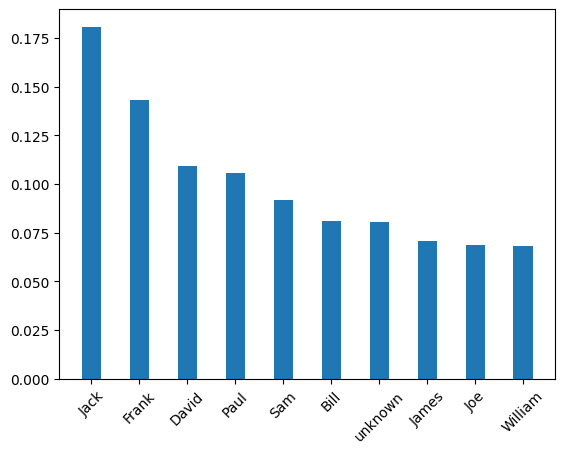

In [20]:
text_1, text_2 = "", "The dealer's name was Jeremy."
probabilities, tokens = run(text_1, text_2, "Jeremy")
plt.bar(np.arange(10), width=0.4, height=probabilities)
plt.xticks(np.arange(10), tokens, rotation=45)

<ipython-input-5-bd627d0b4373>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


([<matplotlib.axis.XTick at 0x7a88b0be56f0>,
 [Text(0, 0, 'unknown'),
  Text(1, 0, 'revealed'),
  Text(2, 0, 'Jack'),
  Text(3, 0, 'Paul'),
  Text(4, 0, 'David'),
  Text(5, 0, 'William'),
  Text(6, 0, 'announced'),
  Text(7, 0, 'given'),
  Text(8, 0, 'spoken'),
  Text(9, 0, 'Christopher')])

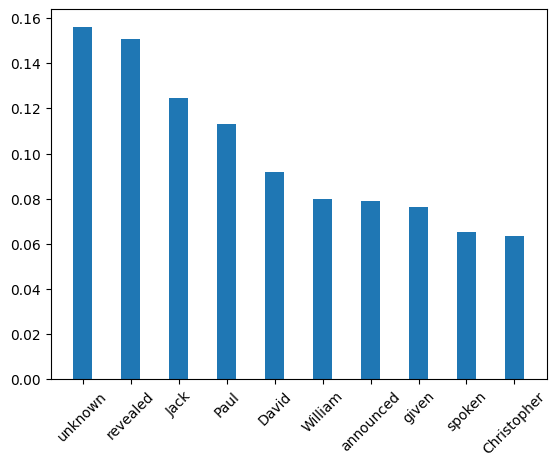

In [21]:
text_1, text_2 = "", "The president's name was Jeremy."
probabilities, tokens = run(text_1, text_2, "Jeremy")
plt.bar(np.arange(10), width=0.4, height=probabilities)
plt.xticks(np.arange(10), tokens, rotation=45)

['[CLS]', 'Do', 'you', 'know', 'her', 'profession', '?', '[SEP]', 'She', 'works', 'as', 'a', 'doctor', '[SEP]']
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
12
torch.Size([1, 14, 28996])


<ipython-input-15-c65878b668f7>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


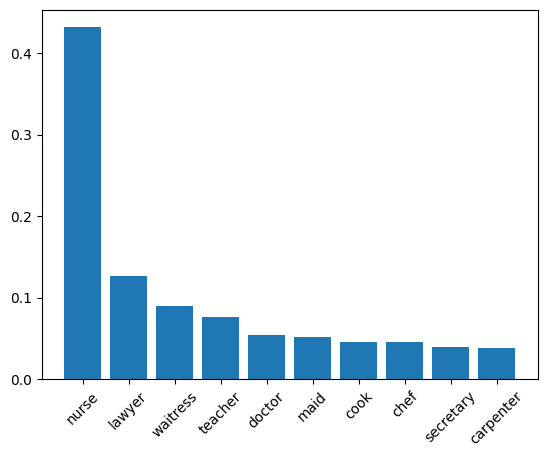

In [ ]:
text_1 = "Do you know her profession ?"
text_2 = "She works as a doctor"
run(text_1, text_2, "doctor")

torch.Size([1, 14, 28996])


<ipython-input-11-858e2d584fc9>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


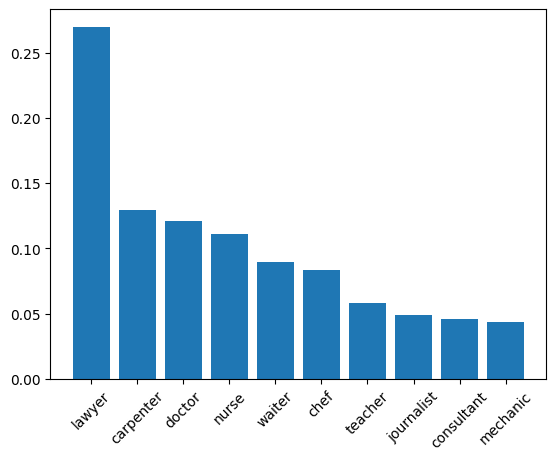

In [ ]:
text_1 = "Do you know his job ?"
text_2 = "He works as a doctor"
run(text_1, text_2, 12)

['[CLS]', 'Do', 'you', 'know', 'her', 'job', '?', '[SEP]', 'She', 'works', 'as', 'a', 'doctor', '[SEP]']
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
12
torch.Size([1, 14, 28996])


<ipython-input-15-c65878b668f7>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


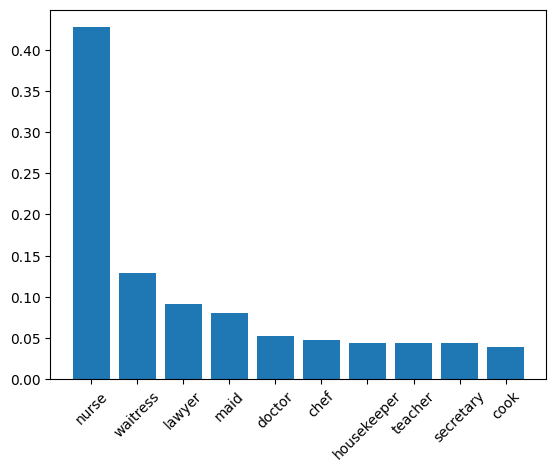

In [ ]:
text_1 = "Do you know her job ?"
text_2 = "She works as a doctor"
run(text_1, text_2, "doctor")

['[CLS]', 'Do', 'you', 'know', 'his', 'job', '?', '[SEP]', 'He', 'is', 'twenty', 'and', 'he', 'works', 'as', 'a', 'doctor', '[SEP]']
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
16
torch.Size([1, 18, 28996])


<ipython-input-15-c65878b668f7>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


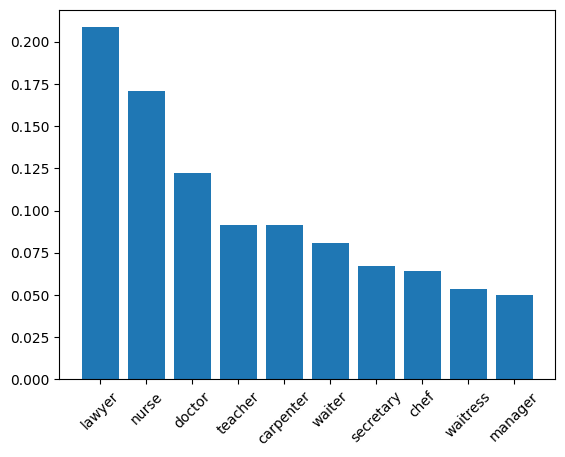

In [ ]:
text_1 = "Do you know his job ?"
text_2 = "He is twenty and he works as a doctor"
run(text_1, text_2, "doctor")

['[CLS]', 'Do', 'you', 'know', 'her', 'job', '?', '[SEP]', 'She', 'is', 'twenty', 'and', 'she', 'works', 'as', 'a', 'doctor', '[SEP]']
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
16
torch.Size([1, 18, 28996])


<ipython-input-15-c65878b668f7>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(topk_values)


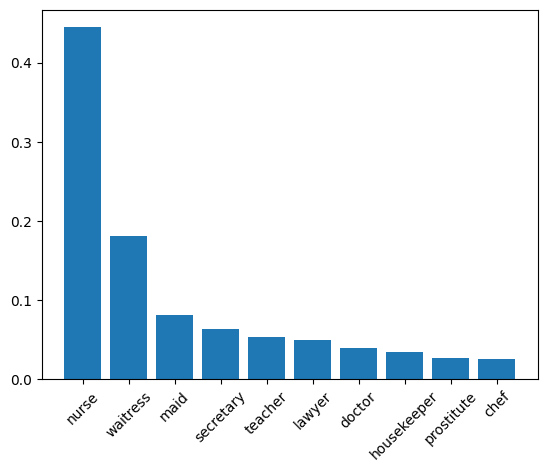

In [ ]:
text_1 = "Do you know her job ?"
text_2 = "She is twenty and she works as a doctor"
run(text_1, text_2, "doctor")

In [ ]:
x = np.arange(10)
bar_width = 0.5

plt.bar(x - bar_width/2, women_counts, width=bar_width, label='Women', color='skyblue')
plt.bar(x + bar_width/2, men_counts, width=bar_width, label='Men', color='salmon')

In [ ]:
a =["aa","ee", "uu","kk"]
a[np.array([1, 3])]

TypeError: only integer scalar arrays can be converted to a scalar index